In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
! pip install -q datasets tqdm

In [3]:
import collections
import random
import os
import time
import json
from PIL import Image
import io
import urllib
import uuid
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset

In [184]:
# Add the relevant ISO code for the language you want to work with.
# iso639_3_letter_code = "hau"
# iso639_3_letter_code = "tha"
iso639_3_letter_code = "kir"

# Download the language specific dataset from HF.3333
dataset = load_dataset("sil-ai/bloom-captioning", iso639_3_letter_code, 
                       use_auth_token=True, download_mode='force_redownload')

/opt/conda/lib/python3.7/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset bloom_captioning downloaded and prepared to /root/.cache/huggingface/datasets/sil-ai___bloom_captioning/kir/0.0.0/8efe15718b4a50170c9add75b453aec13ec1c5216111d21815428536fe5913ca. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [185]:
! rm -rf images
! mkdir images

USER_AGENT = get_datasets_user_agent()

def fetch_single_image(image_url, timeout=None, retries=0):
    request = urllib.request.Request(
        image_url,
        data=None,
        headers={"user-agent": USER_AGENT},
    )
    with urllib.request.urlopen(request, timeout=timeout) as req:
        if 'png' in image_url:
          png = Image.open(io.BytesIO(req.read())).convert('RGBA')
          png.load() # required for png.split()
          background = Image.new("RGB", png.size, (255, 255, 255))
          background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          background.save(image_path, 'JPEG', quality=80)
        else:
          image = Image.open(io.BytesIO(req.read()))
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          image.save(image_path)
    return image_path

def fetch_images(batch, num_threads, timeout=None, retries=3):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image_path"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

num_threads = 20
dataset = dataset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

In [186]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [187]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [188]:
# Get unique train images
encode_train = sorted(set(dataset['train']['image_path']))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

# Get unique test images
encode_test = sorted(set(dataset['test']['image_path']))

# Feel free to change batch_size according to your system configuration
image_dataset_test = tf.data.Dataset.from_tensor_slices(encode_test)
image_dataset_test = image_dataset_test.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset_test):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


In [189]:
# Add some special tokens and clean up new line characters.
train_captions = [f"<start> {x} <end>" for x in dataset['train']['caption']]
train_captions = [x.replace('\n', ' ') for x in train_captions]
test_captions = [f"<start> {x} <end>" for x in dataset['test']['caption']]
test_captions = [x.replace('\n', ' ') for x in test_captions]

In [190]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 25
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

caption_dataset_test = tf.data.Dataset.from_tensor_slices(test_captions)
cap_vector_test = caption_dataset_test.map(lambda x: tokenizer(x))

In [191]:
# Create some mas between images, vectors, and captions
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(dataset['train']['image_path'], cap_vector):
  img_to_cap_vector[img].append(cap)

img_name_train = []
cap_train = []
for imgt in list(img_to_cap_vector.keys()):
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_to_cap_vector_test = collections.defaultdict(list)
for img, cap in zip(dataset['test']['image_path'], cap_vector_test):
  img_to_cap_vector_test[img].append(cap)

img_name_test = []
cap_test = []
for imgv in list(img_to_cap_vector_test.keys()):
  capv_len = len(img_to_cap_vector_test[imgv])
  img_name_test.extend([imgv] * capv_len)
  cap_test.extend(img_to_cap_vector_test[imgv])

In [192]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [193]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [194]:
dataset_tf = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset_tf = dataset_tf.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_tf = dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_tf = dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

In [195]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.W3 = tf.keras.layers.Dense(units) # -----------------> Vatsal Changed this
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    # ------------------> This too
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(features) + 
                                         self.W3(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [196]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [197]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [198]:
# Initialize the encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [199]:
# Training config.
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function to use during training.
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [200]:
# Make sure we save checkpoints during training
checkpoint_path = "./checkpoints/kir/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [201]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [202]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [203]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [218]:
# Adjust this depending on how long you want to train
EPOCHS = 15

# Train our model!
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset_tf):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.1986
Epoch 1 Loss 0.227322
Time taken for 1 epoch 12.92 sec

Epoch 2 Batch 0 Loss 0.1854
Epoch 2 Loss 0.224236
Time taken for 1 epoch 12.35 sec

Epoch 3 Batch 0 Loss 0.2804
Epoch 3 Loss 0.220978
Time taken for 1 epoch 12.36 sec

Epoch 4 Batch 0 Loss 0.2288
Epoch 4 Loss 0.209515
Time taken for 1 epoch 12.21 sec

Epoch 5 Batch 0 Loss 0.1841
Epoch 5 Loss 0.207545
Time taken for 1 epoch 12.51 sec

Epoch 6 Batch 0 Loss 0.1751
Epoch 6 Loss 0.214535
Time taken for 1 epoch 12.85 sec

Epoch 7 Batch 0 Loss 0.2043
Epoch 7 Loss 0.214592
Time taken for 1 epoch 12.42 sec

Epoch 8 Batch 0 Loss 0.1983
Epoch 8 Loss 0.215356
Time taken for 1 epoch 12.57 sec

Epoch 9 Batch 0 Loss 0.1932
Epoch 9 Loss 0.219705
Time taken for 1 epoch 12.17 sec

Epoch 10 Batch 0 Loss 0.1859
Epoch 10 Loss 0.218566
Time taken for 1 epoch 12.27 sec

Epoch 11 Batch 0 Loss 0.2516
Epoch 11 Loss 0.210107
Time taken for 1 epoch 12.91 sec

Epoch 12 Batch 0 Loss 0.2247
Epoch 12 Loss 0.205700
Time taken for 1 epo

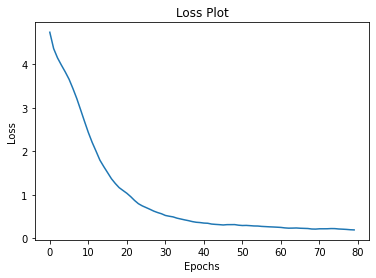

In [219]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Infer

In [220]:
def predict(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(tf.constant(predicted_id)).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [221]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [222]:
# import pandas as pd

# test_data = pd.read_csv('../input/purdue-test-dataset/test.csv')
# test_data.head()

In [223]:
del id_list

In [224]:
id_list = test_data.loc[test_data['ISO639-3'] == 'kir']['Id'].to_list()

In [225]:
# test_data['Predicted'] = ''

In [232]:
test_data.head()

,Id,ImageURL,ISO639-3,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,https://bloom-vist.s3.amazonaws.com/%D0%A6%D0%...,kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%82%...,tha,[UNK]
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%80%...,tha,[UNK] [UNK] [UNK]
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,https://bloom-vist.s3.amazonaws.com/Gallina%20...,hau,shanshani ta buɗe baƙi wajen saka ƙwallon. sha...
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,https://bloom-vist.s3.amazonaws.com/%D0%9C%D0%...,kir,[UNK]


In [231]:
for id in id_list:
    image_url = test_data.loc[test_data['Id'] == id]['ImageURL'].to_list()[0]
    idx = test_data.loc[test_data['Id'] == id].index[0]
    image_path = fetch_single_image(image_url)
    image = image_path
    result, attention_plot = predict(image)
    predicted_caption = ' '.join(result).replace(' <end>', '')
    test_data.iloc[idx]['Predicted'] = predicted_caption

In [233]:
test_data.sample(20)

,Id,ImageURL,ISO639-3,Predicted
147,d9b53da4-a571-4302-b761-5bbdfc29f272_tha,https://bloom-vist.s3.amazonaws.com/%E0%B8%AB%...,tha,[UNK] [UNK]
138,ccf36b42-542d-4f61-8d36-78358a1031eb_kir,https://bloom-vist.s3.amazonaws.com/%D0%A6%D0%...,kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
68,614e084a-e741-463d-8937-8ba020e34383_kir,https://bloom-vist.s3.amazonaws.com/%D0%9A%D0%...,kir,"– [UNK] [UNK] Жакшы кал, [UNK] [UNK] эмесмин. ..."
14,0fc50966-6770-43f4-a30c-547300dd9972_kir,https://bloom-vist.s3.amazonaws.com/%D0%9C%D0%...,kir,[UNK] нече [UNK] нече күндөн бери [UNK] ошонду...
175,a6e9670c-ea80-4f22-9c42-4ae8fbc33daa_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,[UNK] Ал эми даана көрүнүп турат. Ал эми [UNK]...
17,1278528d-1cfe-4516-ad37-f700823444dd_hau,https://bloom-vist.s3.amazonaws.com/Gallina%20...,hau,"lokacin da kaza tana shigowa gida, sai ta gamu..."
70,638cc9ec-b4db-4013-91be-8b4754232678_tha,https://bloom-vist.s3.amazonaws.com/%E0%B8%AB%...,tha,[UNK] [UNK]
179,d53dd565-3710-47eb-b63d-a94610719d69_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
132,c489e001-b61e-4c35-8fdc-3be025e7ac4e_hau,https://bloom-vist.s3.amazonaws.com/01/image13...,hau,"allah ya ɗaga hannunsa bisan bahar ya mutu, ma..."
31,2bf59dd7-c1a4-4bfa-839b-e2672c52c9a8_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%82%...,tha,[UNK] แต่กลับมายิงนก [UNK] [UNK] [UNK]


In [276]:
final_data = test_data.drop(['ImageURL','ISO639-3'],axis = 1)

In [277]:
final_data.sample(10)

,Id,Predicted
62,5d9cf303-71f7-4366-8af3-7ac33e1e8a29_tha,[UNK] [UNK]
164,1c1fa153-f419-4a3d-b90f-1e3e8f230fb7_tha,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
15,1001fff1-27a4-4423-bf17-8c0f99643b99_kir,[UNK] [UNK] [UNK]
103,9ff8dc3a-f4c3-410e-8da3-56c73230b584_kir,[UNK] Дем алыш күнү Асел [UNK] [UNK] менен Күч...
26,20daeb3b-d1f3-43ce-a1ee-b80008e3f8be_hau,babban ɗan allah ya ce mai wani babbar hanya k...
108,a6d42e51-0a51-4277-aeaa-d5a3b3bf4792_tha,ผลบุญหนุนนำ ช่วยค้ำจุนให้ สุขกายสุขใจ ...
128,c03d20e3-70a4-4bd0-a5a8-74ce44fed2bf_kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
188,2347c532-28f7-444c-ba91-6c266cc07a9a_hau,sai wata rana sun rayu a babban abu.
134,c690c9e7-4b6f-4d50-9692-1c9ec93a434e_kir,Үйдүн [UNK] [UNK] [UNK] [UNK] [UNK] Атам да [U...


In [272]:
final_data['new_predicted'] = " "

In [273]:
final_data.head()

,Id,Predicted,new_predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...,
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,[UNK],
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,[UNK] [UNK] [UNK],
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,shanshani ta buɗe baƙi wajen saka ƙwallon. sha...,
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,[UNK],


In [268]:
import re

for i in range(len(final_data)):
    row = final_data.iloc[i]
    caption = row['Predicted']
    final_caption = ''
    caption = caption.replace('[UNK]'," ")
    final_caption = re.sub(' +', ' ', caption)
    final_data.iloc[i]['new_predicted'] = final_caption

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [269]:
final_data = final_data.drop(['Predicted'],axis = 1)
final_data = final_data.rename(columns={"new_predicted": "Predicted"})
final_data.head()

,Id,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,


In [ ]:
os.getcwd()

In [278]:
final_data.to_csv(r'submission.csv',index = False)

In [279]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [ ]:
image_path = fetch_single_image('https://bloom-vist.s3.amazonaws.com/Gallina%20y%20milpi%C3%A9s/jv01iw2o.hic.png')

In [ ]:
image_path

In [ ]:
image = image_path
result, attention_plot = predict(image)
predicted_caption = ' '.join(result).replace(' <end>', '')
print('Prediction Caption:', predicted_caption)

# Display image
from IPython.display import Image as im
im(filename=image)

In [ ]:
# Predict a caption for a random test image
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
result, attention_plot = predict(image)
predicted_caption = ' '.join(result).replace(' <end>', '')
print('Prediction Caption:', predicted_caption)

# Display image
from IPython.display import Image as im
im(filename=image)

In [ ]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
result, attention_plot = predict(image)
predicted_caption = ' '.join(result).replace(' <end>', '')
print('Prediction Caption:', predicted_caption)

# Display image
from IPython.display import Image as im
im(filename=image)

In [ ]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
result, attention_plot = predict(image)
predicted_caption = ' '.join(result).replace(' <end>', '')
print('Prediction Caption:', predicted_caption)

# Display image
from IPython.display import Image as im
im(filename=image) 

In [ ]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
result, attention_plot = predict(image)
predicted_caption = ' '.join(result).replace(' <end>', '')
print('Prediction Caption:', predicted_caption)

# Display image
from IPython.display import Image as im
im(filename=image) 

In [ ]:
import pandas as pd

test_data = pd.read_csv('../input/purdue-test-dataset/test.csv')
test_data.head()